# COGS 108 - Final Project

### Group Members
- Aaron Lee (A14836759)
- Cassie Zhu (A13738990)
- Tina Chen (A13237421)
- Dillon Handal (A15571525)
- Emery Lin

### Overview
This project explores the relationship between anime fans' age and level of engagement to investigate our hypothesis that older anime fans display less engagement in their hobby. We first visualized various pertinent aspects of the dataset such as the age distribution of users, the total anime watched by each user vs their age, and the number of days each user spent watching anime vs their age. Then, we analyzed average days spent watching anime, total anime watched, and anime currently watched to support our hypothesis. We elaborated on possible ethical concerns or biases and limitations with our dataset, and finally conluded that our hypothesis is correct.

### Intro
Anime is the Japanese word for animation. Outside of Japan, the term refers to a popular style of Japanese animation characterized by vibrant graphics and colorful characters. It has an appeal that bypasses borders and nationalities, captivating people of all ages across the globe.

### Research Question
How does an anime fan's age influence their level of engagement with the general anime community?

Our dataset supplies all the necessary information that we will need to answer this question.

### Background & Prior Work
This project examines the relationship between user age vs engagement. We define engagement as the total number of anime watched. The dataset we are utilizing has historically been used to train machine learning and recommender systems, so there is very little preSince the dataset we are looking at has been used mostly for machine learning and recommender systems, our research question is completely different and therefore, there is not much work that has been done previously on it. We had looked at the following two sources:
- https://myanimelist.net/
- https://www.kaggle.com/CooperUnion/anime-recommendations-database

MyAnimeList (MAL) contains the entirety of the anime database and the secondary kaggle link was a smaller fraction of it. However, the kaggle dataset here was more difficult to use because it was a smaller dataset compared to the one we found.

### Hypothesis
Hypothesis: As anime fans age, they watch less anime and engage less with the community. 

Explanation: We believe our hypothesis is correct because older people have more obligations to their job, family, etc. Thus, older anime fans will have less free time to indulge in their hobby.

# Dataset

Name: MyAnimeList Dataset

Link to the dataset: https://www.kaggle.com/azathoth42/myanimelist

Number of observations: anime_filtered.csv, animelists_filtered.csv and users_filtered.csv collectively contain
+ 116,133 unique users with demographic data
+ 35,802,010 records in anime lists
+ 14,474 unique anime

The cleaned versions (anime_cleaned.csv, animelists_cleaned.csv, users_cleaned.csv) removed a negligible amount of observations.

Description: A cleaned kaggle dataset populated by information from MyAnimeList, one of the largest consolidations of anime titles and user ratings/info in the fandom.

# Data Analysis

### Setup

In [1]:
%matplotlib inline

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from bs4 import BeautifulSoup
from time import sleep
from IPython.display import clear_output

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

from collections import defaultdict

In [2]:
# Configure libraries
# The seaborn library makes plots look nicer
sns.set()
sns.set_context('talk')

# Don't display too many rows/cols of DataFrames
pd.options.display.max_rows = 10
pd.options.display.max_columns = 10

# Round decimals when displaying DataFrames
pd.set_option('precision', 2)

In [3]:
# import csv
usersCleaned = pd.read_csv('users_cleaned.csv')

In [4]:
usersCleaned.head()

,username,user_id,user_watching,user_completed,user_onhold,...,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
0,karthiga,2255153,3,49,1,...,2013-03-03 00:00:00,2014-02-04 01:32:00,7.43,0.0,3391
1,Damonashu,37326,45,195,27,...,2008-02-13 00:00:00,2017-07-10 06:52:54,6.15,6.0,4903
2,bskai,228342,25,414,2,...,2009-08-31 00:00:00,2014-05-12 16:35:00,8.27,1.0,9701
3,terune_uzumaki,327311,5,5,0,...,2010-05-10 00:00:00,2012-10-18 19:06:00,9.70,6.0,697
4,Bas_G,5015094,35,114,6,...,2015-11-26 00:00:00,2018-05-10 20:53:37,7.86,0.0,1847


### Data Cleaning

The kaggle set is pre-cleaned. According to the description of the kaggle set, the cleaning involved:
+ recalculating "watch time" and "seen episodes" for users whose number of "watched" or "rewatched" episodes of an anime were greater than the total number of episodes for that anime
+ replacing "last online time" of users whose "last online time" were strange values (like year 1900) with their last animelist update timestamp
+ removing users who were too obviously young or old
+ removing 6 users with suspiciously large amounts of "seen episodes"

To ensure that the data is cleaned, we examined the distribution of user vs age below to check for any outliers that still needed pruning. We also performed manual examination of random sections of the data to spotcheck. 

To comply with the Safe Harbour method, we add an "age" column below.


In [5]:
# add age column to usersFiltered data frame
# convert birth_date to age because birth_date is private data.
now = pd.Timestamp('now')
usersCleaned['birth_date'] = pd.to_datetime(usersCleaned['birth_date'], format='%Y-%m-%d')
usersCleaned['age'] = (now - usersCleaned['birth_date']).astype('<m8[Y]').astype(int)

### Data Visualization

Since we're interested in the age distribution, we first plot age vs users to see if we have a balanced dataset.

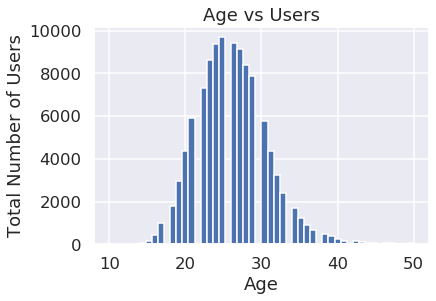

In [6]:
# plot histogram of age range
histogram = usersCleaned.hist(column="age", bins=50)
plt.title('Age vs Users')
plt.xlabel('Age')
plt.ylabel('Total Number of Users')
plt.show()

This data has a normal distibution. Ages range from 10 to 50 years old, and the majority of users are around 25 years old.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


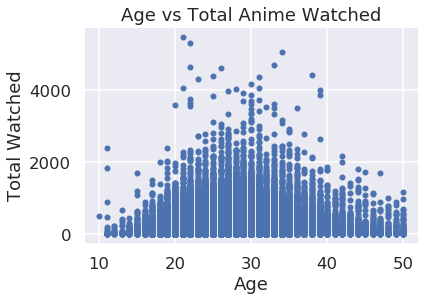

In [7]:
# plot age groups to total anime watching or completed
usersCleaned['total_watched'] = usersCleaned['user_watching'] + usersCleaned['user_completed']

plot = usersCleaned[['age', 'total_watched']].plot.scatter('age', 'total_watched')
plt.title('Age vs Total Anime Watched')
plt.xlabel('Age')
plt.ylabel('Total Watched')
plt.show()

We again see a normal distribution of data, with quite a few outliers among the different age ranges that have a higher number of total watched anime than normal. Interestingly, the distribution seems to be centered on 30 years old rather than 25 years old (as in the age vs users graph).

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


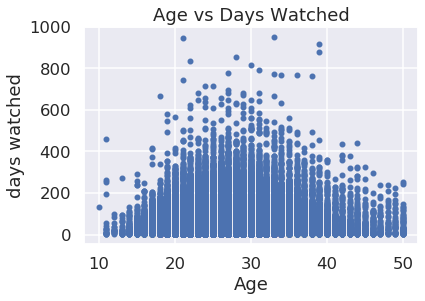

In [8]:
#scatter plot for age vs days watched
df = pd.DataFrame(usersCleaned)
df['age'] = pd.to_numeric(df['age'])
df['user_days_spent_watching'] = pd.to_numeric(df['user_days_spent_watching'])
#scatter plot 
ax = df.plot( x = 'age',y = 'user_days_spent_watching',kind = 'scatter')
plt.ylabel('days watched')
plt.xlabel('Age')
plt.title('Age vs Days Watched')

plt.show()

This has a similar distribution to Age vs Total Watched, where the amount of time spent watching anime is concentrated around the 20s to mid 30s, with 30 years old as the seeming average.

### Data Analysis & Results

Our earlier visualizations showed that all our users fall between the age range of 10-50, so we can limit our analysis to these ages.

To better understand how these visualizations show __age vs time spent watching__, we break it down into smaller age ranges of 5. First, we take a look at the average days spent watching for each age range:

In [9]:
#gets the data of average and total days watched for age groups\
age_sum = defaultdict(int)
age_count = defaultdict(int)

for i, r in df.iterrows():
    if r['age'] <= 50:
        age_range = str(((r['age']) // 5) * 5)
        age_sum[age_range] += r['user_days_spent_watching']
        age_count[age_range] += 1

       Age  Average Days Watched  Average % of Year Spent Watching
0  10 - 14                 46.16                              0.13
1  15 - 19                 48.40                              0.14
2  20 - 24                 57.48                              0.16
3  25 - 29                 63.11                              0.18
4  30 - 34                 70.05                              0.20
5  35 - 39                 74.50                              0.21
6  40 - 44                 70.14                              0.20
7  45 - 49                 57.66                              0.16
8  50 - 54                 53.50                              0.15


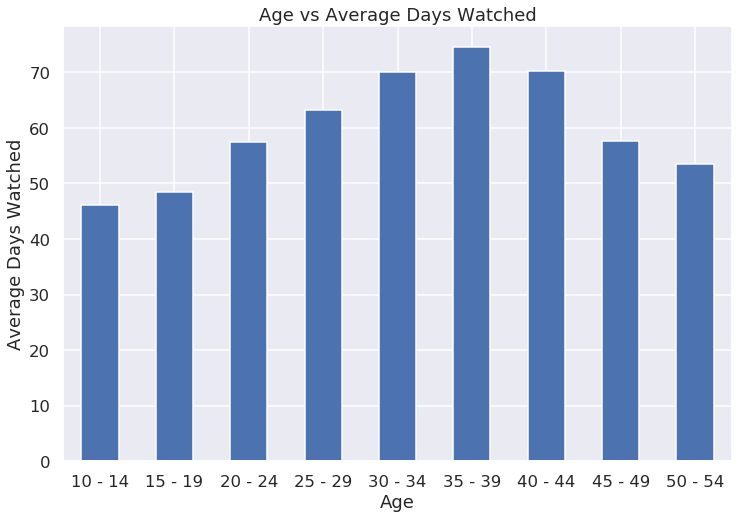

In [10]:
#average days watched per age group
avg_days = []
avg_percent_of_year = []
ranges = sorted(age_sum.items())
for age, sum in ranges:
    avg_days.append(sum/age_count[age])
    avg_percent_of_year.append(sum/age_count[age]/356)
    
dataAverage = {'Age':['10 - 14','15 - 19','20 - 24','25 - 29','30 - 34','35 - 39','40 - 44','45 - 49','50 - 54'], 
        'Average Days Watched': avg_days,
        'Average % of Year Spent Watching': avg_percent_of_year} 
#plot data
dfGroupedAverage = pd.DataFrame(dataAverage)
ax1 = dfGroupedAverage.plot.bar(x='Age', y='Average Days Watched', rot=0,figsize = (12,8),title = 'Age vs Average Days Watched',legend = False)
ax1.set_ylabel('Average Days Watched')
print(dfGroupedAverage)

Breaking this down further, we can see that the age group 35 - 39 has the highest average of days spent watching anime at about 74 days. The rest of the ages show a nice bell curve around that peak. This analysis does support our hypothesis that that anime fans watch less as they age, but the difference in average days watched actually doesn't differ that much between the age ranges, the lowest being 13% of the year spent watching anime and the highest being 21%, making it a 8% difference.

However, our earlier "Age vs Users" visualization shows a large dropoff in users after 30, with there barely being any users ~50. The average days watched of users of 40 doesn't drop off quite as much though and actually remains higher than the average days of users below 20 when people are starting to watch anime, which means that even though the amount of people who continue to watch anime past their 30s decreases steeply, as we hypothesized, those who continue to watch are still dedicated and invest a similar amount of time into their hobby.

These averages however may be skewed by the small ammount of users certain age ranges may have. So to better reflect the average days watched we take into account the total number of users in each age range and look at the weighted average number of days each age range has watched:

       Age  Average Watched Weighted
0  10 - 14                      0.05
1  15 - 19                      2.83
2  20 - 24                     18.83
3  25 - 29                     25.85
4  30 - 34                     11.26
5  35 - 39                      2.50
6  40 - 44                      0.45
7  45 - 49                      0.13
8  50 - 54                      0.03


Text(0, 0.5, 'Average Days Watched Weighted')

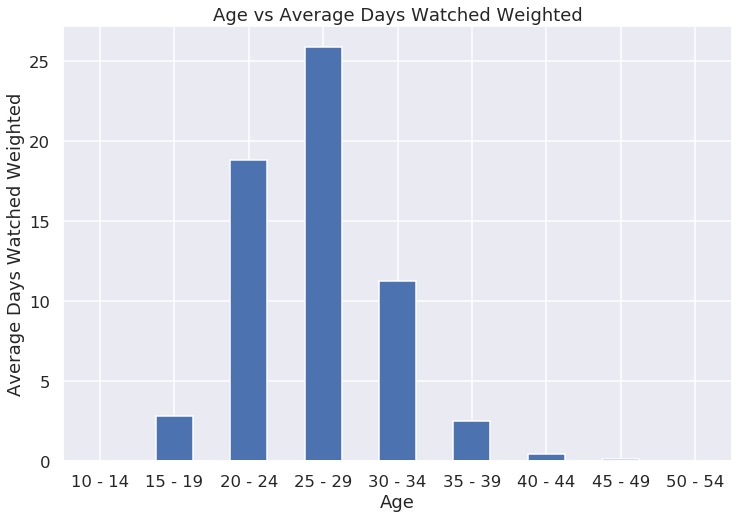

In [11]:
#finds the weighted average of age groups
dataAverageWatchedWeighted = {'Age':['10 - 14','15 - 19','20 - 24','25 - 29','30 - 34','35 - 39','40 - 44','45 - 49','50 - 54'], 
        'Average Watched Weighted': [float(sum)/len(df) for age, sum in ranges]}
dfAvg_watchedWeighted = pd.DataFrame(dataAverageWatchedWeighted)
dfAvg_watchedWeighted
print(dfAvg_watchedWeighted)
ax2 = dfAvg_watchedWeighted.plot.bar(x='Age', y='Average Watched Weighted', rot=0,figsize = (12,8), title = 'Age vs Average Days Watched Weighted',legend = False)
ax2.set_ylabel('Average Days Watched Weighted')


As expected, this bar graph more closely resembles that of the "Age vs User" visualization earlier and we see that users between the ages of 25 and 29 have the most average days watched. So even though the averages may appear not too different at first, when we take into account the differences in number of users for each age group we see that users in their 20s to 30s have watched the most anime. 

We use linear regression to take a closer at days vs user numbers, which shows that age does indeed significantly predict days spent watching, as shown by the p-value of 0.

In [12]:
#Linear Regression Shows that age does significantly predict days spent watching. This is shown by p-value of 0.
outcome_1, predictors_1 = patsy.dmatrices('user_days_spent_watching ~ age',df)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                               OLS Regression Results                               
Dep. Variable:     user_days_spent_watching   R-squared:                       0.009
Model:                                  OLS   Adj. R-squared:                  0.009
Method:                       Least Squares   F-statistic:                     1002.
Date:                      Thu, 12 Dec 2019   Prob (F-statistic):          5.56e-219
Time:                              23:25:23   Log-Likelihood:            -5.9742e+05
No. Observations:                    108711   AIC:                         1.195e+06
Df Residuals:                        108709   BIC:                         1.195e+06
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

Another thing we'd like to look at is __age vs how many anime currently watched__, to see if our hypothesis of user engagement decreasing also holds.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


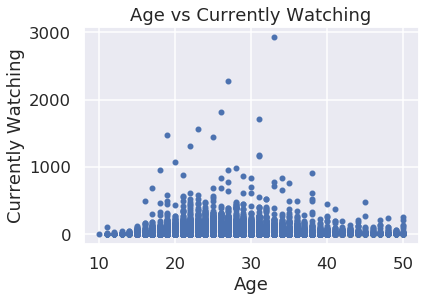

In [13]:
#graphs of age vs currently Watching
ax3 = df.plot( x = 'age',y = 'user_watching',kind = 'scatter')
plt.ylabel('Currently Watching')
plt.xlabel('Age')
plt.title('Age vs Currently Watching')

plt.show()

From this visualization we see several very obvious outliers, such as the user around age 34 who's currently watching almost 3000 shows, but generally the highest number of currently watching falls under the age range of 20s to mid 30s.

If we take a look at the averages of each user in the age ranges...

In [14]:
#gets the data of average and total currently watching for age groups
age_sum = defaultdict(int)
age_count = defaultdict(int)

for i, r in df.iterrows():
    if r['age'] <= 50:
        age_range = str(((r['age']) // 5) * 5)
        age_sum[age_range] += r['user_watching']
        age_count[age_range] += 1

       Age  Average Watching
0  10 - 14             10.16
1  15 - 19             14.06
2  20 - 24             14.55
3  25 - 29             14.59
4  30 - 34             15.23
5  35 - 39             16.85
6  40 - 44             19.02
7  45 - 49             21.87
8  50 - 54             22.96


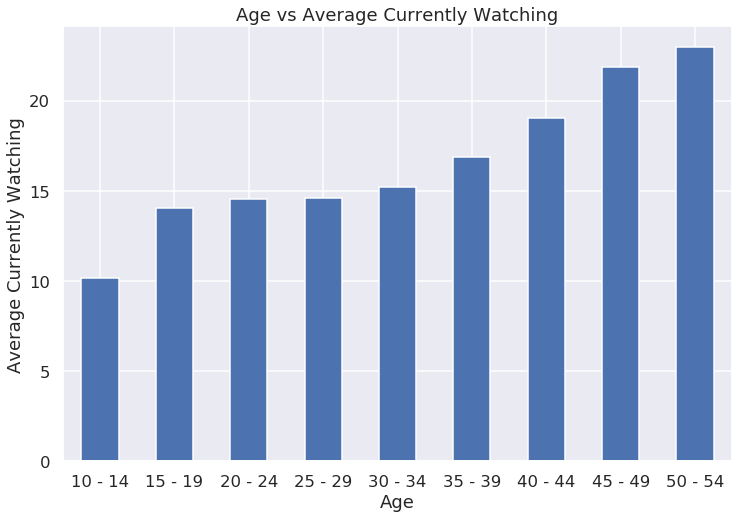

In [15]:
#average currently watching per age group
ranges = sorted(age_sum.items())
dataAverageWatching = {'Age':['10 - 14','15 - 19','20 - 24','25 - 29','30 - 34','35 - 39','40 - 44','45 - 49','50 - 54'], 
        'Average Watching': [float(sum)/age_count[age] for age, sum in ranges]}

dfAvg_watching = pd.DataFrame(dataAverageWatching)
ax1 = dfAvg_watching.plot.bar(x='Age', y='Average Watching', rot=0,figsize = (12,8),title = 'Age vs Average Currently Watching',legend = False)
ax1.set_ylabel('Average Currently Watching')
print(dfAvg_watching)


... we curiously see that the average currently watched actually increases with age, which seems to contradict our hypothesis that involvement with anime decreases as age increases. One possible explanation could be that because the user is older there is simply more anime available to watch (since more anime is created over time, so the number of existing anime always increases with age), so there is a larger selection to choose from. Another possible explanation is that users naturally forget to change the status of anime from "currently watching" to "finished" or "dropped" after adding it to their currently watching list. Thus, with a greater age, the user has more time to add more anime to their currently watching list (and forget to change its status) than younger users. In addition, they may also be more likely to forget to change the status due to increased responsibilities in their life occupying their mind more than their anime list, like we hypothesized.

However, if we take into account the number of users in each age group by looking at the weighted averages for anime currently watching we see different results. 

       Age  Average Watching Weighted
0  10 - 14                       0.01
1  15 - 19                       0.82
2  20 - 24                       4.77
3  25 - 29                       5.97
4  30 - 34                       2.45
5  35 - 39                       0.57
6  40 - 44                       0.12
7  45 - 49                       0.05
8  50 - 54                       0.01


Text(0, 0.5, 'Average Currently Watching Weighted')

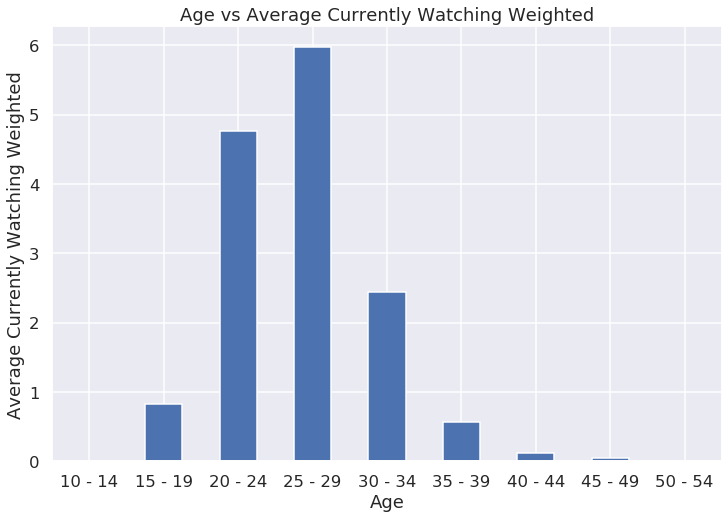

In [16]:
#finds the weighted average of age groups
dataAverageWatchingWeighted = {'Age':['10 - 14','15 - 19','20 - 24','25 - 29','30 - 34','35 - 39','40 - 44','45 - 49','50 - 54'], 
        'Average Watching Weighted': [float(sum)/len(df) for age, sum in ranges]}
dfAvg_watchingWeighted = pd.DataFrame(dataAverageWatchingWeighted)
dfAvg_watchingWeighted
print(dfAvg_watchingWeighted)
ax2 = dfAvg_watchingWeighted.plot.bar(x='Age', y='Average Watching Weighted', rot=0,figsize = (12,8), title = 'Age vs Average Currently Watching Weighted',legend = False)
ax2.set_ylabel('Average Currently Watching Weighted')

By looking at the weighted averages we see that users between the ages of 25-29 are currently watching the most anime. So even though on average users above the age of 30 may be currently watching more anime than younger users, if we take into account the fact that there are fewer users in those older age groups we see that the users in their 20s to 30s are the ones currently watching the most anime. 

# Privacy / Ethics Considerations

Our dataset consists solely of public data, which is readily available with a quick google search. However, the data needed to be cleaned because it contains sensitive user data such as birthdays. Following the Safe Harbor method, we removed birthdays from our dataset and replaced it with a more generalized "age" column. In regards to the other user data, our data is in compliance with MyAnimeList's Terms of Service so our data usage is safe. Furthermore, users on MyAnimeList can control whether their information is public or private. So, those who do not want their personal data to be public can simply restrict who is able to view their profiles.

We have also anonymized any sensitive user data, so the analysis resulting from this project does not contain sensitive personal data.

# Conclusion & Discussion

We have found our hypothesis to be true. We examined the average amount of days users spent watching vs their age and found it to be a normal distribution. The peak is ages 35 - 39 with an average of 74.44 days. We found that the average days watched doesn't drop off as much as expected, but it is still enough to show that, as we hypothesized, engagement drops off as anime fans age.

The results of the project may be biased because the dataset does not contain the sum total of all anime fans. This is merely a sampling of fans who have decided to log their watch lists on MyAnimeList. This form of analysis also excludes those who watch anime prolifically but do not log it on MyAnimeList. Additionally, it is possible that users who were prolific anime watchers in their youth no longer watch, but their data remains. Because age is based off birthday, it might appear that they are an older active fan, when in actuality they no longer a fan. Thus, the analysis might conclude that there are more older, high engagement fans than there truly are.
